# Data Pre- Processing for NLP

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
pd.set_option("display.max_columns",None)

import warnings
warnings.filterwarnings('default')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


In [73]:
# Importing the saved data from EDA

X_train = pd.read_csv('PCA_Xtrain_amazon_updated.csv')
X_val = pd.read_csv('PCA_Xtest_amazon_updated.csv')

In [65]:
X_train.shape

(1440000, 18)

In [74]:
X_val.shape

(360000, 18)

In [89]:
"""y_train = pd.read_csv('y_train_amazon_updated.csv')
y_val = pd.read_csv('y_test_amazon_updated.csv') """

"y_train = pd.read_csv('y_train_amazon_updated.csv')\ny_val = pd.read_csv('y_test_amazon_updated.csv') "

In [87]:
data = pd.read_csv('EDA_filtered_Rating_Amazon_data.csv')

In [90]:
# Step1 defining features and target

# Define the target variable (y) and features (X)
# The `Rating_Sentiment` column appears to be the target variable based on the data structure.
# Features will be all numerical columns from 'Review_str_len' to the end.
#X = data.loc[:, 'Review_str_len':'years']
# Drop non-numeric columns except target/label
X = data.drop(['Rating_Sentiment'], axis=1)
y = data['Rating_Sentiment']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1800000, 15)
Target shape: (1800000,)


In [71]:
y_train.shape

(1440000, 1)

In [72]:
y_val.shape

(360000, 1)

In [100]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Original classes: {le.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}\n")

Original classes: ['Negative' 'Neutral' 'Positive']
Encoded labels: [0 1 2]



In [104]:
#Step 2: Split the data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")

Training features shape: (1440000, 15)
Validation features shape: (360000, 15)
Training target shape: (1440000,)
Validation target shape: (360000,)


# Modelling

## Traditional Machine Learning Model

### Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression 
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

#Model intialization
#lr_model = LogisticRegression()

# Training the model
#lr_model.fit(X_train,y_train)
#print("Number of iterations performed:", lr_model.n_iter_)

# Make predictions and evaluate
#y_pred = lr_model.predict(X_val)

In [105]:
text_features = 'WordNet_Lemmatizer'
numerical_features = ['Review_str_len', 'Title_str_len', 'Review_wtoken_cnt', 'lexical_diversity', 'review_removed_cnt']

In [ ]:
# --- 3. Define the shared preprocessing and PCA steps ---
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=500, stop_words='english'), text_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='drop'
)

final_n_components = 83

pipeline_PCA = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=final_n_components)),
])

# --- 4. Create a dictionary of models to experiment with ---
models = {
    'logistic_regression' : LogisticRegression(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'NaiveBayes': MultinomialNB(),  # Note: Naive Bayes works best with sparse data, so it might not benefit from PCA.
    'KNN': KNeighborsClassifier(n_neighbors=5) # n_neighbors is a hyperparameter to tune
}

# --- 5. Loop through the models, create a pipeline, fit, and score ---
print("--- Starting Model Experimentation ---")
for model_name, model_instance in models.items():
    print(f"\nTraining and evaluating the {model_name} model...")
    
    # Create the full pipeline for the current model
    full_pipeline = Pipeline([
        ('preprocessing_and_pca', pipeline_PCA),
        ('model', model_instance)
    ])
    
    try:
        # Fit the pipeline on the training data
        full_pipeline.fit(X_train, y_train)
        
        # Evaluate the model on the validation data
        score = full_pipeline.score(X_val, y_val)
        
        print(f"Accuracy for {model_name}: {score:.4f}")
    
    except Exception as e:
        print(f"An error occurred while training {model_name}: {e}")


--- Starting Model Experimentation ---

Training and evaluating the logistic_regression model...


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for logistic_regression: 0.6116

Training and evaluating the XGBoost model...


In [97]:
model_logistic_reg = Pipeline([
    ('pipeline_PCA',pipeline_PCA),
('logistic_regression',LogisticRegression(random_state=42)),
])

# --- 4. Fit the entire pipeline on the training data ONLY ---
print("\nFitting the complete pipeline on the training data...")
model_logistic_reg.fit(X_train, y_train)

# --- 5. Evaluate the model on the unseen test data ---
score = model_logistic_reg.score(X_val, y_val)
print(f"Model accuracy on the test set: {score:.4f}")


Fitting the complete pipeline on the training data...
Model accuracy on the test set: 0.6116


In [ ]:
#Using tfidf - vectorizer
tfidf_vect = TfidfVectorizer(max_features=100, stop_words=stop_words_list, ngram_range=(1,2), min_df=30)
tfidf_vect.fit(df.review_punc_stop_words_removed.str.join(' '))
tfidf_X = tfidf_vect.transform(df.review_punc_stop_words_removed.str.join(' '))

tfidf_df = pd.DataFrame(tfidf_X.toarray(), columns= tfidf_vect.get_feature_names_out())
print(tfidf_df.head())

In [33]:
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))

Logistic Regression Performance:
Accuracy: 0.7469
Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.83      0.87    120224
     Neutral       0.64      0.56      0.60    119710
    Positive       0.69      0.85      0.77    120066

    accuracy                           0.75    360000
   macro avg       0.75      0.75      0.74    360000
weighted avg       0.75      0.75      0.75    360000



# KNN (K-Nearest Neighbor)

In [38]:
from sklearn.neighbors import KNeighborsClassifier 

#Model intialization
knn_model = KNeighborsClassifier()

# Training the model
knn_model.fit(X_train,y_train)

# Make predictions and evaluate
y_pred = lr_model.predict(X_val)

In [39]:

print("KNN Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))

KNN Performance:
Accuracy: 0.7469
Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.83      0.87    120224
     Neutral       0.64      0.56      0.60    119710
    Positive       0.69      0.85      0.77    120066

    accuracy                           0.75    360000
   macro avg       0.75      0.75      0.74    360000
weighted avg       0.75      0.75      0.75    360000



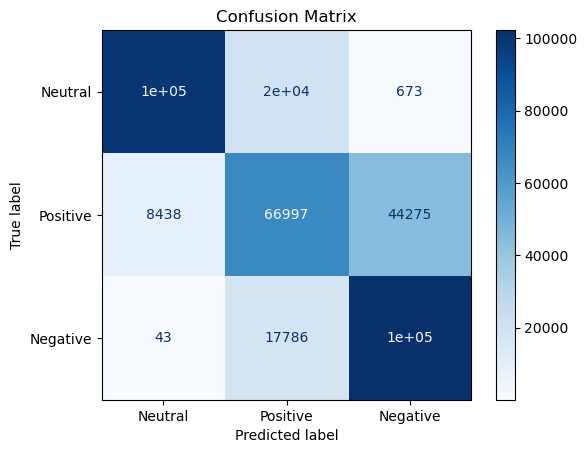

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# 1. Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# 2. Get the unique labels from the test set for display
class_labels = y_val.unique()

# 3. Create a ConfusionMatrixDisplay object
# The 'display_labels' argument provides the labels for the axes.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# 4. Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB

#Model intialization
nb_model = MultinomialNB()

# Training the model
nb_model.fit(X_train,y_train)
print("Number of iterations performed:", lr_model.n_iter_)

# Make predictions and evaluate
y_pred = nb_model.predict(X_val)

In [13]:


print("Multinomial Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))

Multinomial Naive Bayes Performance:
Accuracy: 0.6429
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.73      0.81    120224
     Neutral       0.57      0.50      0.53    119710
    Positive       0.53      0.70      0.60    120066

    accuracy                           0.64    360000
   macro avg       0.67      0.64      0.65    360000
weighted avg       0.67      0.64      0.65    360000



# Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

#Model intialization
rf_model = RandomForestClassifier()

# Training the model
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_val)

In [15]:
print("Random Forest Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_rf))

Random Forest Classifier Performance:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00    120224
     Neutral       1.00      1.00      1.00    119710
    Positive       1.00      1.00      1.00    120066

    accuracy                           1.00    360000
   macro avg       1.00      1.00      1.00    360000
weighted avg       1.00      1.00      1.00    360000




# XGBoost

In [16]:
!pip install xgboost

In [17]:
# can you find any feature which is indicating data leakage, what are the most important feature which contributed to accuracy, find the feature importance tells which made XGboost better. correlation analysos
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# 1. Initialize LabelEncoder
le = LabelEncoder()

# 2. Fit the encoder on the training labels and transform both training and test labels
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val) # Note: Corrected y_test to y_val as per your variable name

# 3. Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softprob',
                              eval_metric='mlogloss')

# 4. Train the model with the NUMERICAL labels
# This is the crucial fix: use y_train_encoded
xgb_model.fit(X_train, y_train_encoded)

# 5. Make predictions
# Make sure you are passing the correct validation data
y_pred_encoded = xgb_model.predict(X_val)

# 6. Decode the predictions back to their original labels for readability
y_pred = le.inverse_transform(y_pred_encoded)

# 7. Evaluate the model using the original labels
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

XGBoost Classifier Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00    120224
     Neutral       1.00      1.00      1.00    119710
    Positive       1.00      1.00      1.00    120066

    accuracy                           1.00    360000
   macro avg       1.00      1.00      1.00    360000
weighted avg       1.00      1.00      1.00    360000



# Gradient Boost Classifier

In [18]:
"""from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred)) """

'from sklearn.ensemble import GradientBoostingClassifier\n\ngb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)\n\n# Train the model\ngb_model.fit(X_train, y_train)\n\n# Make predictions\ny_pred = gb_model.predict(X_test)\n\n# Evaluate the model\nprint("Gradient Boosting Classifier Performance:")\nprint(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")\nprint("\nClassification Report:")\nprint(classification_report(y_val, y_pred)) '

### Support Vector Machines (SVMs)

In [19]:
from sklearn.svm import SVC

#Model intialization
#svc_model = SVC()

# Training the model
#svc_model.fit(X_train,y_train)

# Make predictions and evaluate
#y_pred = svc_model.predict(X_val)

In [20]:
""" print("SVM Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred)) """

' print("SVM Performance:")\nprint(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")\nprint("Classification Report:")\nprint(classification_report(y_val, y_pred)) '

# Kfold validation and Hyperparameter Tuning and their performance using pipeline

In [59]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline

import multiprocessing as mp
mp.set_start_method("spawn", force=True)

In [60]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Define models and their hyperparameter grids
models_and_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {'model__C': [0.1, 1, 10, 100], 'model__penalty': ['l1', 'l2']}
    ),
    'Multinomial Naive Bayes': (
        MultinomialNB(),
        {'model__alpha': [0.1, 0.5, 1.0, 2.0]}
    ),
    'Random Forest Classifier': (
        RandomForestClassifier(random_state=42),
        {'model__n_estimators': [50, 100, 200], 'model__max_depth': [None, 10, 20]}
    ),
    'Gradient Boosting Classifier': (
        GradientBoostingClassifier(random_state=42),
        {'model__n_estimators': [50, 100], 'model__learning_rate': [0.05, 0.1]}
    ),
    'XGBoost Classifier': (
        xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, random_state=42),
        {'model__n_estimators': [50, 100], 'model__learning_rate': [0.05, 0.1]}
    ),
    'Support Vector Machine (SVC)': (
        SVC(random_state=42),
        {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
    )
}

# 4. Set up K-Fold Cross-Validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# 5. Loop through models, perform tuning, and evaluate
for name, (model, params) in models_and_params.items():
    print(f"\n{'='*50}\nStarting hyperparameter tuning for: {name}\n{'='*50}")

    # Use the appropriate target variable for XGBoost
    if name == 'XGBoost Classifier':
        y_train_target = y_train_encoded
        y_val_target = y_val_encoded
        # You will need to uncomment this line for XGBoost prediction later
        y_val_original = y_val
    else:
        y_train_target = y_train
        y_val_target = y_val
    
    # Create a pipeline including the TfidfVectorizer.
    # This prevents data leakage during cross-validation.
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('model', model)
    ])

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )

    # Fit the grid search on the raw text data (X_train)
    grid_search.fit(X_train, y_train_target)

    # Print results
    print(f"Best parameters found for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Evaluate on the validation set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    # If using XGBoost, decode the predictions back to original labels
    if name == 'XGBoost Classifier':
        y_pred = le.inverse_transform(y_pred)
        y_val_true = y_val_original
    else:
        y_val_true = y_val

    print("\nValidation Set Performance:")
    print(f"Accuracy: {accuracy_score(y_val_true, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_val_true, y_pred, zero_division=0))



Starting hyperparameter tuning for: Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits


ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 63, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.

--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1222, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1389, in check_X_y
    check_consistent_length(X, y)
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py", line 475, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [107, 1152000]


In [58]:
# Optimization technique using GridSearchCV
#Define models and their hyperparameter grids
models_and_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {'model__C': [0.1, 1, 10, 100], 'model__penalty': ['l1', 'l2']}
    ),
    'Multinomial Naive Bayes': (
        MultinomialNB(),
        {'model__alpha': [0.1, 0.5, 1.0, 2.0]}
    ),
    'Random Forest Classifier': (
        RandomForestClassifier(random_state=42),
        {'model__n_estimators': [50, 100, 200], 'model__max_depth': [None, 10, 20]}
    ),
   # 'Gradient Boosting Classifier': (
   #     GradientBoostingClassifier(random_state=42),
   #     {'model__n_estimators': [50, 100], 'model__learning_rate': [0.05, 0.1]}
   # ),
    'XGBoost Classifier': (
        xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, random_state=42),
        {'model__n_estimators': [50, 100], 'model__learning_rate': [0.05, 0.1]}
    )#,
    #'Support Vector Machine (SVC)': (
    #    SVC(random_state=42),
    #    {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
    #)
}

# 4. Set up K-Fold Cross-Validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# 5. Loop through models, perform tuning, and evaluate
for name, (model, params) in models_and_params.items():
    print(f"\n{'='*50}\nStarting hyperparameter tuning for: {name}\n{'='*50}")

    # Use the appropriate target variable for XGBoost
    if name == 'XGBoost Classifier':
        y_train_target = y_train_encoded
        y_test_target = y_val_encoded
    else:
        y_train_target = y_train
        y_test_target = y_val

    # Create a pipeline
    pipeline = Pipeline([
        #('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('model', model)
    ])

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train_target)

    # Print results
    print(f"Best parameters found for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    # If using XGBoost, decode the predictions back to original labels
    if name == 'XGBoost Classifier':
        y_pred = le.inverse_transform(y_pred)
    
    print("\nTest Set Performance:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))



Starting hyperparameter tuning for: Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/s

KeyboardInterrupt: 

ase/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 139, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 451, in _logistic_regression_path
    opt_res = optimiz

In [42]:
!pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


In [57]:
from sklearn.model_selection import KFold, cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Define a single objective function for all models
def objective(params):
    """Objective function for Hyperopt.
    This function takes hyperparameters and returns a loss (negative accuracy)
    using K-Fold cross-validation.
    """
    model_name = params.pop('model_type')
    
    if model_name == 'LogisticRegression':
        model = LogisticRegression(**params, solver='liblinear', random_state=42)
    elif model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**params, random_state=42)
    elif model_name == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier(**params, random_state=42)
    elif model_name == 'MultinomialNB':
        model = MultinomialNB(**params)
    elif model_name == 'SVC':
        model = SVC(**params, random_state=42)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    else:
        raise ValueError("Invalid model type specified.")

    # Perform K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # We use negative accuracy as the loss to minimize
    score = cross_val_score(model, X_train, y_train_target, cv=kf, scoring='accuracy', n_jobs=-1).mean()
    loss = 1 - score
    
    return {'loss': loss, 'status': STATUS_OK, 'model_name': model_name, 'params': params}

# 4. Define the search space for each model's hyperparameters
space = hp.choice('classifier_type', [
    {
        'model_type': 'LogisticRegression',
        'C': hp.loguniform('C_logreg', np.log(0.001), np.log(100.0)),
        'penalty': hp.choice('penalty_logreg', ['l1', 'l2'])
    },
    {
        'model_type': 'MultinomialNB',
        'alpha': hp.uniform('alpha_mnb', 0.0, 1.0)
    },
    {
        'model_type': 'RandomForestClassifier',
        'n_estimators': scope.int(hp.quniform('n_estimators_rf', 10, 200, 10)),
        'max_depth': scope.int(hp.quniform('max_depth_rf', 3, 20, 1)),
        'min_samples_split': hp.uniform('min_samples_split_rf', 0.1, 1.0),
        'min_samples_leaf': hp.uniform('min_samples_leaf_rf', 0.1, 0.5)
    },
    #{
    #    'model_type': 'GradientBoostingClassifier',
    #    'n_estimators': scope.int(hp.quniform('n_estimators_gb', 50, 250, 10)),
    #    'learning_rate': hp.loguniform('learning_rate_gb', np.log(0.01), np.log(0.5)),
    #    'max_depth': scope.int(hp.quniform('max_depth_gb', 2, 10, 1))
    #},
    {
        'model_type': 'XGBClassifier',
        'n_estimators': scope.int(hp.quniform('n_estimators_xgb', 50, 250, 10)),
        'learning_rate': hp.loguniform('learning_rate_xgb', np.log(0.01), np.log(0.5)),
        'max_depth': scope.int(hp.quniform('max_depth_xgb', 2, 10, 1))
    }#,
    #{
     #   'model_type': 'SVC',
     #   'C': hp.loguniform('C_svc', np.log(0.01), np.log(100)),
     #   'kernel': hp.choice('kernel_svc', ['linear', 'rbf'])
    #}
])

# 5. Run the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  # Number of different hyperparameter combinations to test
    trials=trials
)

# 6. Extract and print the best results
best_result = sorted(trials.results, key=lambda x: x['loss'])[0]

print("\n--- Hyperopt Optimization Results ---")
print(f"Best Model: {best_result['model_name']}")
print(f"Best Hyperparameters: {best_result['params']}")
print(f"Best Validation Accuracy: {1 - best_result['loss']:.4f}")

  1%|█▏                                                                                                                     | 1/100 [00:12<20:10, 12.23s/trial, best loss: 0.6669777777777778]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

  3%|███▉                                                                                                                               | 3/100 [05:53<3:03:01, 113.21s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

  4%|█████▎                                                                                                                              | 4/100 [07:09<2:37:48, 98.63s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

  5%|██████▌                                                                                                                             | 5/100 [07:11<1:41:06, 63.86s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

  6%|███████▉                                                                                                                            | 6/100 [07:13<1:07:05, 42.82s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

  7%|█████████▏                                                                                                                         | 7/100 [12:53<3:36:54, 139.94s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

  8%|██████████▍                                                                                                                        | 8/100 [15:16<3:36:15, 141.04s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

  9%|███████████▊                                                                                                                       | 9/100 [15:34<2:35:25, 102.47s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


 10%|█████████████                                                                                                                      | 10/100 [15:40<1:48:50, 72.56s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

 11%|██████████████▍                                                                                                                    | 11/100 [15:41<1:15:26, 50.86s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

 12%|███████████████▉                                                                                                                     | 12/100 [15:43<52:40, 35.91s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

 15%|███████████████████▌                                                                                                              | 15/100 [23:17<3:30:06, 148.32s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

 16%|████████████████████▊                                                                                                             | 16/100 [25:34<3:23:00, 145.01s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


 17%|██████████████████████                                                                                                            | 17/100 [25:42<2:23:38, 103.83s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

 18%|███████████████████████▌                                                                                                           | 18/100 [25:44<1:40:04, 73.23s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

 19%|████████████████████████▉                                                                                                          | 19/100 [28:18<2:11:30, 97.42s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/minicon

 20%|██████████████████████████▏                                                                                                        | 20/100 [28:38<1:38:48, 74.10s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:23:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:23:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.u

 21%|███████████████████████████▎                                                                                                      | 21/100 [34:39<3:31:02, 160.29s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:29:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:29:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:29:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:29:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

 22%|████████████████████████████▌                                                                                                     | 22/100 [41:32<5:07:08, 236.27s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:35:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

 23%|█████████████████████████████▉                                                                                                    | 23/100 [48:34<6:14:41, 291.97s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

 24%|███████████████████████████████▏                                                                                                  | 24/100 [51:34<5:27:06, 258.24s/trial, best loss: 0.0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

 24%|███████████████████████████████▏                                                                                                  | 24/100 [51:46<2:43:58, 129.45s/trial, best loss: 0.0]



KeyboardInterrupt

